<div class="fluid-row" id="section-header">
    <h2 class="title toc-ignore">Master Data Science & Big Data - ENSIAS</h2>
    <h4 class="author"><em>pacman</em></h4>
    <h4 class="date"><em>January 04, 2018</em></h4>
</div>
<center>
    <h1>
        <u>Social Network Analysis - DataScience.Stackexchange</u>
    </h1>
    <h4>Realized by : Ayoub RMIDI <br><br> Directed by : Ms.&nbsp;Lamia BEN HIBA</h4>
</center>
<div class="fluid-row lead" id="section-header">
    <h2 class="title toc-ignore">Introduction</h2>
    <p>This document provides a complete analysis of a social network based on the Question & Answer coming from 
    Stack Exchange web site and exactly the data science community corresponding to datascience.stackexchange.com
    Both networks are based on the latest data dump from stack Exchange 2017, basedon posts (questions) and  comments (answers), a directed graph will be created where nodes are users who either created a post or commented on a post, and a directed edge from user A to user B indicates that A commented on a post created by B.
    </p>
    <img src="procedure" width="604" height="302">
    <p>As shown in the schema above, the complete analysis will be constructed by following this steps :</p>
    <ol>
        <li>Identifying the research problem</li>
        <li>Developping the hypothesis</li>
        <li>Reseacrh design</li>
        <li>Acquisition of network data</li>
        <li>Data cleansing</li>
        <li>Analyse</li>
        <li>Interpret, discuss and present the findings</li>
        <li>Follow-up</li>
    </ol>
</div>

## 1. Identifying the research problem

<p class="lead">The research problem consist on verifying if the majority of data science community's questions were answered or not, in other words check if posts (questions) have more or at least one comments (answers), or not which means that nodes still isolated.</p>

## 2. Developping the hypothesis

<p class="lead">After Identifying the research problem, now it's time to develop the hypothesis in order to confirm or deny one of them</p>
<div class="lead">
    <ul>
        <li>A bigger part of the network consist of isolated nodes, which means that plenty of posts (questions) were not answered in other words Unresolved</li>
        <li>Most of posts in the network consist of connected nodes, which means that majority of posts (questions) were commented (Resolved)</li>
        <li>The network is quite balanced between isolated nodes and connected ones, which means that only half of them were approximatively connected.</li>
    </ul>
</div>

## 4. Acquisition of network data

<p class="lead">The network data set was taken from a public networks data set provided by <a href="https://snap.stanford.edu/data/">Stanford</a></p>

## 5. Data Preprocessing

<p class="lead">The reason behind the data preprocessing is to transform our RAW data to a useful one, so that it becomes easy to analyse, here in this case I will extract only my needed values from the xml files corresponding to users and posts to construct my 'gml' file and export it.</p>

In [1]:
# First of all we import our needed libraries
import pandas as pd
import xml.etree.cElementTree as et
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create a function that convert users data from xml file to a dataframe
def users_xml_to_df(xml_file):
    parsed_xml = et.parse(xml_file)
    dfcols = ['id', 'Reputation', 'DisplayName', 'Views', 'UpVotes', 'DownVotes']
    df_nodes = pd.DataFrame(columns=dfcols)
    
    for node in parsed_xml.getroot():
        _id = node.attrib.get('Id')
        Reputation = node.attrib.get('Reputation')
        DisplayName = node.attrib.get('DisplayName')
        Views = node.attrib.get('Views')
        UpVotes = node.attrib.get('UpVotes')
        DownVotes = node.attrib.get('DownVotes')
         
        df_nodes = df_nodes.append(pd.Series([_id, Reputation, DisplayName, Views, UpVotes, DownVotes],
                                           index=dfcols),
                                           ignore_index=True)
    return df_nodes

In [3]:
# We do the same thing for the posts data to extract edges
def posts_xml_to_df(xml_file):
    parsed_xml = et.parse(xml_file)
    dfcols = ['source', 'target', 'weight']
    df_edges = pd.DataFrame(columns=dfcols)
    
    for node in parsed_xml.getroot():
        date = node.attrib.get('CreationDate')
        year = date.split('-')[0] # target only those posts created in 2017
        if year == '2017':
            source = node.attrib.get('OwnerUserId')
            target = node.attrib.get('ParentId')
            weight = node.attrib.get('Score')
            # here we check if the target is not none
            if target is not None and source is not None and weight is not None:
                df_edges = df_edges.append(pd.Series([source, target, weight], index=dfcols), ignore_index=True)
    return df_edges

In [17]:
# Read the xml files of posts and users so that we get more insight about our data
df_nodes = users_xml_to_df('./datascience.stackexchange.com/Users.xml')

In [18]:
df_edges = posts_xml_to_df('./datascience.stackexchange.com/Posts.xml')

<p class="lead">Let's see how the dataframes head look like so that we can know very well their attributes.</p>

In [19]:
df_nodes.head()

,id,Reputation,DisplayName,Views,UpVotes,DownVotes
0,-1,1,Community,0,764,471
1,1,101,Adam Lear,119,0,0
2,2,101,Geoff Dalgas,4,0,0
3,3,101,hichris123,4,1,3
4,4,101,Ben Collins,6,0,0


In [20]:
df_edges.head()

,source,target,weight
0,20372,14793,2
1,20372,16008,2
2,27533,14314,3
3,20768,16011,1
4,27544,9216,1


<p class="lead">Instead of doing the computation every time we better save them into a csv file so that it becomes easy for loading them again.</p>

In [21]:
# save the dataframes to csv files
df_nodes.to_csv("df_nodes.csv", sep=',', encoding='utf-8', index=False)
df_edges.to_csv("df_edges.csv", sep=',', encoding='utf-8', index=False)

In [4]:
# we load the saved data frames so that we create the network easily
df_nodes = pd.read_csv('df_nodes.csv', sep=',', encoding='utf-8')
df_edges = pd.read_csv('df_edges.csv', sep=',', encoding='utf-8')

In [7]:
# now we need to create the network based on the 2 data frames we got
G = nx.from_pandas_dataframe(df_edges, 'source', 'target', 'weight')

In [10]:
for i in sorted(G.nodes()):
    try:
        G.node[i]['id'] = df_nodes.id[i]
        G.node[i]['Reputation'] = df_nodes.Reputation[i]
        G.node[i]['DisplayName'] = df_nodes.DisplayName[i]
        G.node[i]['Views'] = df_nodes.Views[i]
        G.node[i]['UpVotes'] = df_nodes.UpVotes[i]
        G.node[i]['DownVote'] = df_nodes.DownVotes[i]
    except:
        continue

In [11]:
print('The netwrok contain exactly %s' % G.number_of_nodes() + ' nodes and %s' % G.number_of_edges() + ' edges')

The netwrok contain exactly 3415 nodes and 3242 edges


## 6. Analysis

<p class="lead">As mentioned above, the datascience network consists of 3415 nodes and 3242 edges. we can notice that the number of node is more than the number of edges, indicating that a bigger part of the network consists of isolated nodes. This means that plenty of posts have no answers and therfore unresolved.</p>

In [12]:
# we create the directed graph first based on the undirected one
H = G.to_directed()

In [13]:
# Let's take a look on neighbors of at a particular node (user)
neigbors_of_dileep = list(H.neighbors(38145))
print(neigbors_of_dileep)

[23411, 23268, 326, 22136, 19124, 410, 155, 21982]


<p class="lead">But those are just numbers (ids) we want to get other information about those nodes.</p>

In [14]:
for i in neigbors_of_dileep:
    print(H.node[i])

{'Views': 0, 'DownVote': 0, 'DisplayName': 'Salman Sourav', 'Reputation': 1, 'UpVotes': 0, 'id': 31439}
{'Views': 0, 'DownVote': 0, 'DisplayName': 'JoshVarty', 'Reputation': 101, 'UpVotes': 1, 'id': 31296}
{'Views': 5, 'DownVote': 0, 'DisplayName': 'MB_CE', 'Reputation': 207, 'UpVotes': 4, 'id': 339}
{'Views': 0, 'DownVote': 0, 'DisplayName': 'Richard Mason', 'Reputation': 1, 'UpVotes': 0, 'id': 30154}
{'Views': 0, 'DownVote': 0, 'DisplayName': 'Marc', 'Reputation': 1, 'UpVotes': 0, 'id': 27125}
{'Views': 1, 'DownVote': 0, 'DisplayName': 'in code veritas', 'Reputation': 101, 'UpVotes': 0, 'id': 430}
{'Views': 1, 'DownVote': 0, 'DisplayName': 'Collin McGuire', 'Reputation': 101, 'UpVotes': 0, 'id': 161}
{'Views': 0, 'DownVote': 0, 'DisplayName': 'bharadwaj aldur', 'Reputation': 14, 'UpVotes': 0, 'id': 30000}


### Degree centrality

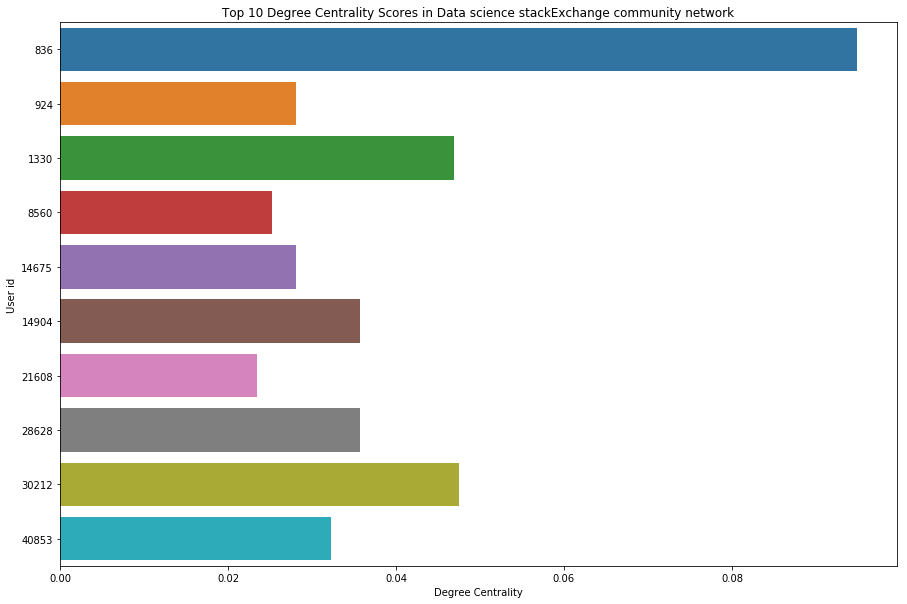

In [15]:
degreeCentrality = nx.degree_centrality(H)
# print degreeCentrality
user_id = []
centrality = []

for key, value in degreeCentrality.items():
    user_id.append(key)
    centrality.append(value)

cent = pd.DataFrame()
cent['user_id'] = user_id
cent['centrality'] = centrality

cent = cent.sort_values(by='centrality', ascending=False)
#print(cent.head())

plt.figure(figsize=(15, 10))
_ = sns.barplot(x='centrality', y='user_id', data=cent[:10], orient='h')
_ = plt.xlabel('Degree Centrality')
_ = plt.ylabel('User id')
_ = plt.title('Top 10 Degree Centrality Scores in Data science stackExchange community network')
plt.show()

<p class="lead">As we can see the node having more centrality degree is the user who's id is 836, and by evidence this node will have a big Reputation, if it is not the highest since he answered many questions, let's see if we are right or no.</p>

In [16]:
df_nodes.loc[df_nodes['id'] == 836]

,id,Reputation,DisplayName,Views,UpVotes,DownVotes
788,836,10192,Neil Slater,547,918,62


In [17]:
print('The highest reputation in this network is %d'% max(df_nodes['Reputation']))

The highest reputation in this network is 10192


In [18]:
# let's visualize this node neighbors
nodes = G.neighbors(836) 
# create an empty list to hold Neil neighbors
neil_neighbor = []
# iterate over Neil neighbors and fill the array
for i in nodes:
    neil_neighbor.append(i)
# here we append the central element
neil_neighbor.append(836)
G_neil_neighbor = G.subgraph(neil_neighbor)

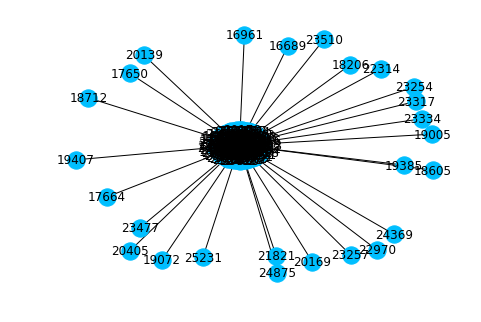

In [19]:
nx.draw(G_neil_neighbor, with_labels=True, node_color='deepskyblue')
plt.show()

<p class="lead">and As it was expected Neil Slater is the node having the highest reputation in this network. Next we can look at betweenness centrality, which measures the degree to which each node is the 'single point of contact', so to answer, between other nodes or cliques. </p>

### Betweeness centrality

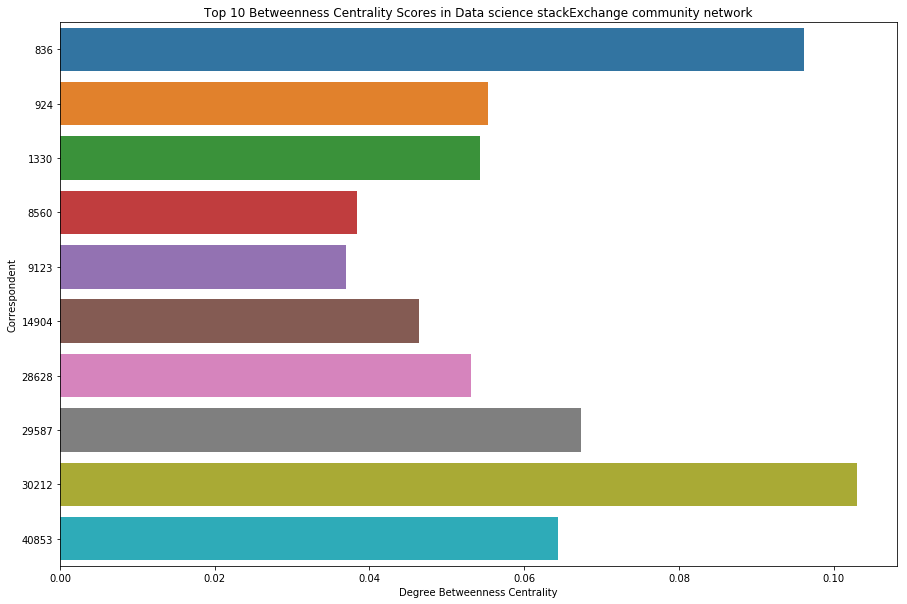

In [20]:
between = nx.betweenness_centrality(H)
# print between
user_id = []
betweenness = []

for key, value in between.items():
    user_id.append(key)
    betweenness.append(value)

bet = pd.DataFrame()
bet['user_id'] = user_id
bet['betweenness'] = betweenness

bet = bet.sort_values(by='betweenness', ascending=False)
#print(bet.head())

plt.figure(figsize=(15, 10))
_ = sns.barplot(x='betweenness', y='user_id', data=bet[:10], orient='h')
_ = plt.xlabel('Degree Betweenness Centrality')
_ = plt.ylabel('Correspondent')
_ = plt.title('Top 10 Betweenness Centrality Scores in Data science stackExchange community network')
plt.show()

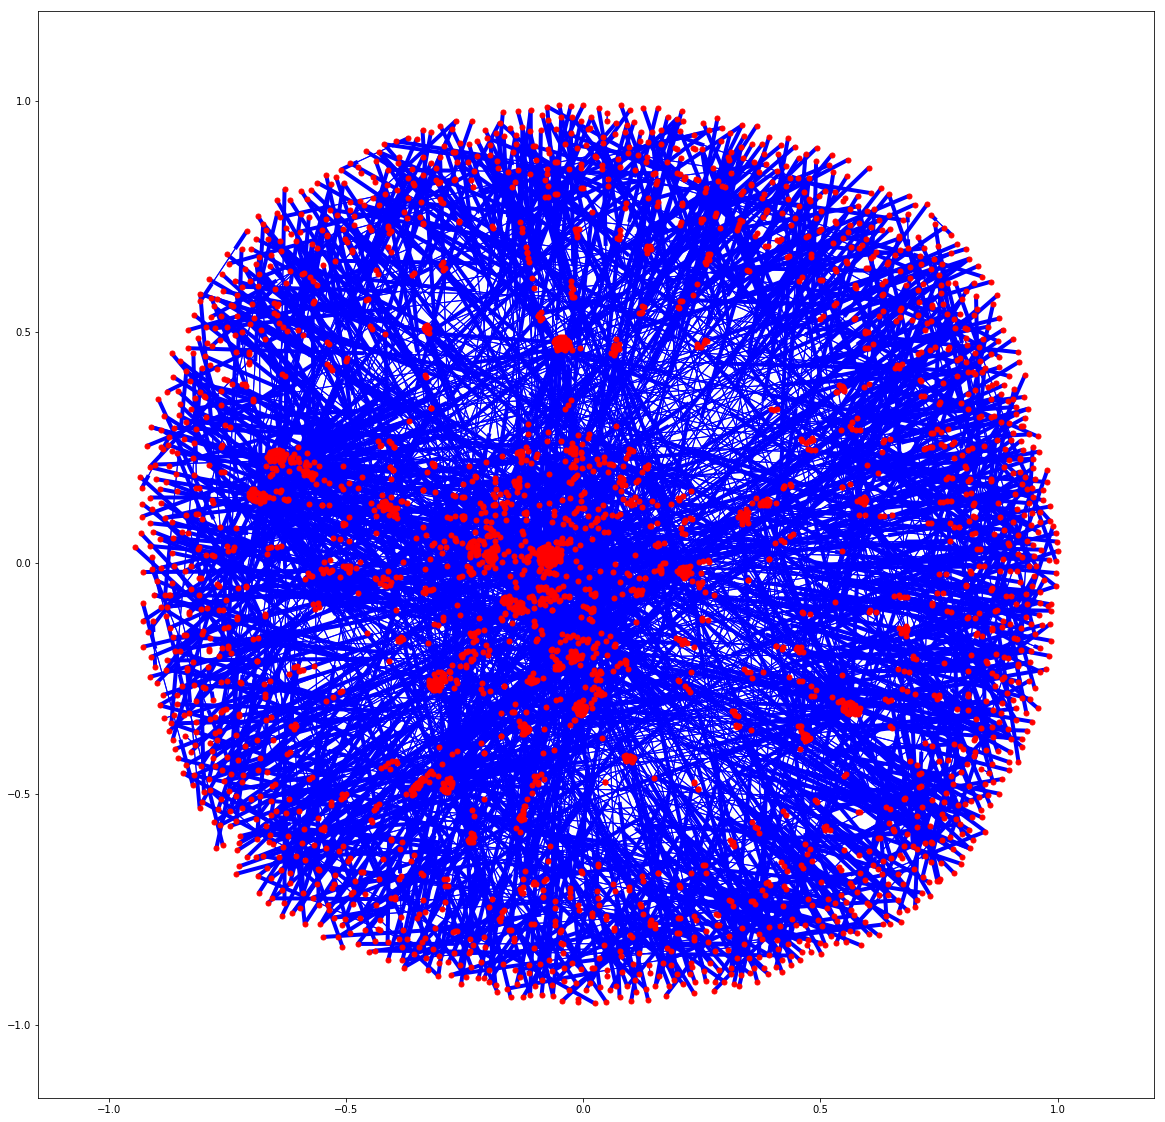

In [36]:
plt.figure(figsize=(20,20))
pos = nx.spring_layout(H, k=.1)
nx.draw_networkx(H, node_size=25, node_color='red', edge_color='blue', with_labels=False)
plt.show()